In [165]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, power_transform
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


import shap
import optuna
import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# from pycaret.regression import *
from pycaret.classification import *

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [94]:
raw_train = pd.read_csv('../data/Train_data.csv')
raw_test = pd.read_csv('../data/Test_data.csv')
ss = pd.read_csv('../data/Sample_submission.csv')

In [4]:
print(raw_train.info())
raw_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       1101 non-null   float64
 1   MIN      1101 non-null   float64
 2   PTS      1101 non-null   float64
 3   FGM      1101 non-null   float64
 4   FGA      1101 non-null   float64
 5   FG%      1101 non-null   float64
 6   3P Made  1101 non-null   float64
 7   3PA      1101 non-null   float64
 8   3P%      1101 non-null   float64
 9   FTM      1101 non-null   float64
 10  FTA      1101 non-null   float64
 11  FT%      1101 non-null   float64
 12  OREB     1101 non-null   float64
 13  DREB     1101 non-null   float64
 14  REB      1101 non-null   float64
 15  AST      1101 non-null   float64
 16  STL      1101 non-null   float64
 17  BLK      1101 non-null   float64
 18  TOV      1101 non-null   float64
 19  Target   1101 non-null   int64  
dtypes: float64(19), int64(1)
memory usage: 172.2 KB
None

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
0,59.0,12.8,3.4,1.3,2.6,51.0,0.2,0.3,50.0,0.7,0.8,78.0,1.1,2.3,3.3,0.5,0.3,0.4,0.5,1
1,31.0,10.7,3.4,1.2,3.3,35.3,0.5,2.1,25.8,0.5,0.9,55.2,0.3,1.1,1.4,0.4,0.3,0.1,0.2,0
2,48.0,9.3,4.5,1.7,3.4,49.7,0.0,0.1,0.0,1.2,1.9,61.5,0.4,0.8,1.2,0.8,0.5,0.4,1.0,0


In [5]:
print(raw_test.info())
raw_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       555 non-null    float64
 1   MIN      555 non-null    float64
 2   PTS      555 non-null    float64
 3   FGM      555 non-null    float64
 4   FGA      555 non-null    float64
 5   FG%      555 non-null    float64
 6   3P Made  555 non-null    float64
 7   3PA      555 non-null    float64
 8   3P%      555 non-null    float64
 9   FTM      555 non-null    float64
 10  FTA      555 non-null    float64
 11  FT%      555 non-null    float64
 12  OREB     555 non-null    float64
 13  DREB     555 non-null    float64
 14  REB      555 non-null    float64
 15  AST      555 non-null    float64
 16  STL      555 non-null    float64
 17  BLK      555 non-null    float64
 18  TOV      555 non-null    float64
dtypes: float64(19)
memory usage: 82.5 KB
None


,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,44.0,13.0,6.6,2.5,5.6,45.3,0.4,1.3,32.7,1.1,1.7,65.3,0.8,0.6,1.4,1.1,0.7,0.2,1.0
1,51.0,9.1,2.7,1.0,2.7,39.0,0.1,0.3,23.5,0.6,0.8,69.8,0.3,0.7,1.0,0.9,0.6,0.1,0.7
2,51.0,15.1,5.7,2.2,5.2,41.2,0.3,0.8,32.5,1.1,1.6,69.1,0.4,1.3,1.7,2.1,0.7,0.0,1.4
3,15.0,7.9,1.9,0.7,2.5,27.0,0.0,0.0,0.0,0.5,0.8,66.7,0.5,1.1,1.5,0.5,0.1,0.1,1.0
4,36.0,14.4,5.8,2.3,5.4,43.1,0.0,0.1,50.0,1.1,1.4,82.0,1.1,1.4,2.4,0.9,0.3,0.2,0.9


In [157]:
df = raw_train.append(raw_test).reset_index(drop=True)

In [158]:
df['GP'] = np.floor(df['GP']).astype(int)

In [159]:
cols = ['MIN', 'PTS', 'FGM', 'FGA', '3P Made', '3PA', 'FTM', 
        'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV']

df = pd.concat([df[cols].multiply(df['GP'], axis='index').astype(int), df[['GP', 'FG%', '3P%', 'FT%', 'Target']]], axis=1)

In [155]:
df = np.floor(df)

In [160]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MIN      1656 non-null   int64  
 1   PTS      1656 non-null   int64  
 2   FGM      1656 non-null   int64  
 3   FGA      1656 non-null   int64  
 4   3P Made  1656 non-null   int64  
 5   3PA      1656 non-null   int64  
 6   FTM      1656 non-null   int64  
 7   FTA      1656 non-null   int64  
 8   OREB     1656 non-null   int64  
 9   DREB     1656 non-null   int64  
 10  REB      1656 non-null   int64  
 11  AST      1656 non-null   int64  
 12  STL      1656 non-null   int64  
 13  BLK      1656 non-null   int64  
 14  TOV      1656 non-null   int64  
 15  GP       1656 non-null   int64  
 16  FG%      1656 non-null   float64
 17  3P%      1656 non-null   float64
 18  FT%      1656 non-null   float64
 19  Target   1101 non-null   float64
dtypes: float64(4), int64(16)
memory usage: 258.9 KB
None

,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,GP,FG%,3P%,FT%,Target
0,755,200,76,153,11,17,41,47,64,135,194,29,17,23,29,59,51.0,50.0,78.0,1.0
1,331,105,37,102,15,65,15,27,9,34,43,12,9,3,6,31,35.3,25.8,55.2,0.0
2,446,216,81,163,0,4,57,91,19,38,57,38,24,19,48,48,49.7,0.0,61.5,0.0
3,2216,896,280,752,104,328,224,264,64,128,192,312,104,8,176,80,37.4,32.9,85.0,1.0
4,1067,336,110,307,0,5,110,179,29,40,69,110,63,11,98,58,36.7,25.0,61.7,0.0


In [140]:
skewness = df.skew().reset_index()
skewness

,index,0
0,MIN,0.875152
1,PTS,1.488554
2,FGM,1.493419
3,FGA,1.415551
4,3P Made,2.632428
5,3PA,2.299810
6,FTM,1.981261
7,FTA,1.969957
8,OREB,1.975007
9,DREB,1.793156


In [103]:
for col in df:
    if col not in ['Target', '3P%']:
        df[col] = power_transform(df[[col]], ).ravel()

In [104]:
skewness['after'] = df.skew().reset_index(drop=True)

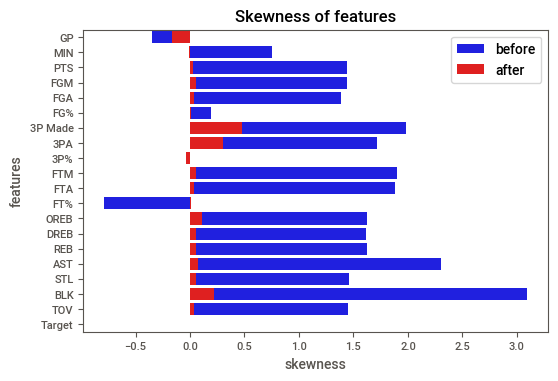

In [105]:
sns.barplot(y=skewness['index'], x=skewness[0], color='blue', label='before')
sns.barplot(y=skewness['index'], x=skewness['after'], color='red', label='after')
plt.xlabel('skewness')
plt.ylabel('features')
plt.title('Skewness of features')
plt.legend()
plt.show()

In [167]:
target_col = 'Target'
mask = df[target_col].isna() == True

train = df.loc[~mask]
train[target_col] = train[target_col].astype(int)

test = df.loc[mask].drop(target_col, axis=1)

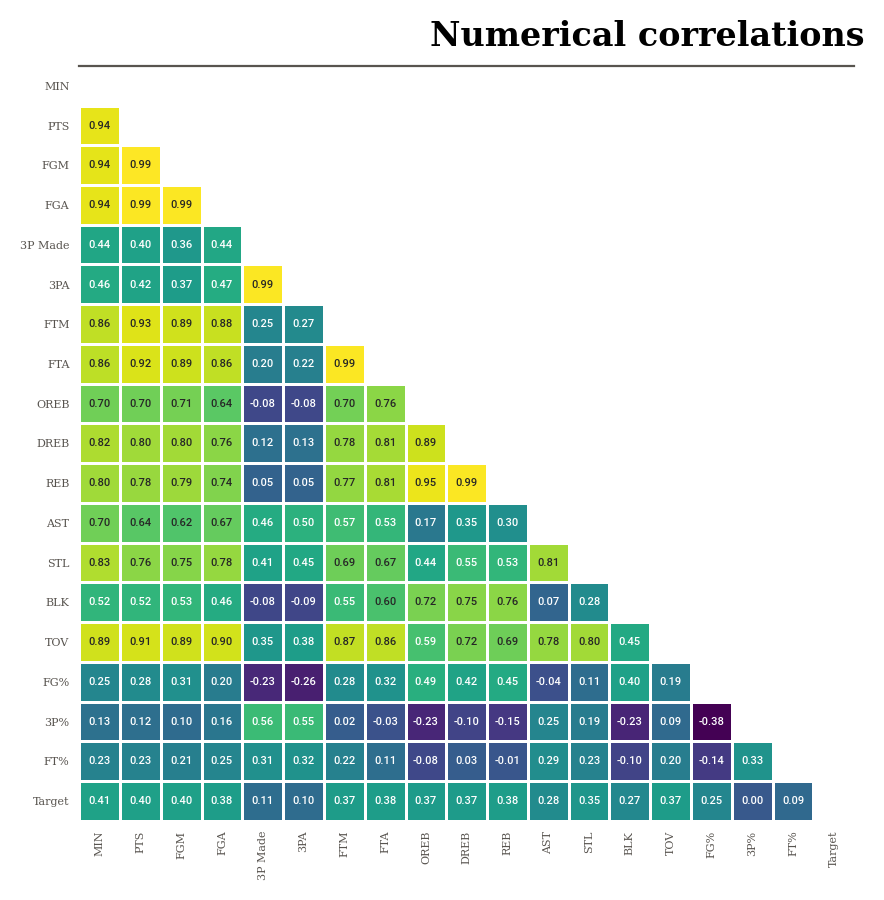

In [142]:
corr = train.corr()

# Setting up figure and axes
fig = plt.figure(figsize=(5, 5), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0.8)
ax0 = fig.add_subplot(gs[0, 0]) # create axis

mask = np.triu(corr)
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=0.5, cmap='viridis', ax=ax0, annot_kws={'fontsize': 4})

ax0.set_yticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=4)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=4)

ax0.spines['top'].set_visible(True)
ax0.tick_params(axis='both', which='both', length=0)

fig.text(0.91, 0.90, 'Numerical correlations', fontweight='bold', 
         fontfamily='serif', fontsize=12, ha='right')
# fig.text(0.91, 0.88, '''
# We observe here that performance 
# in one area is strongly correlated 
# to peformance in other areas.
# It is also interesting how
# negatively correlated free lunches 
# are with performance, 
# speaking to parental 
# socio-economic status.''', 
#          fontweight='light', fontfamily='serif', fontsize=6, va='top', ha='right')

plt.tight_layout()
plt.show()

In [108]:
train.to_csv('../data/clean_train1.csv', index=False)
test.to_csv('../data/clean_test1.csv', index=False)

In [168]:
X = train.drop('Target', axis=1)
y = train['Target']

In [169]:
X

,MIN,PTS,FGM,FGA,3P Made,3PA,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,GP,FG%,3P%,FT%
0,755,200,76,153,11,17,41,47,64,135,194,29,17,23,29,59,51.0,50.0,78.0
1,331,105,37,102,15,65,15,27,9,34,43,12,9,3,6,31,35.3,25.8,55.2
2,446,216,81,163,0,4,57,91,19,38,57,38,24,19,48,48,49.7,0.0,61.5
3,2216,896,280,752,104,328,224,264,64,128,192,312,104,8,176,80,37.4,32.9,85.0
4,1067,336,110,307,0,5,110,179,29,40,69,110,63,11,98,58,36.7,25.0,61.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,406,220,88,191,0,4,39,58,29,34,63,24,14,14,29,49,46.6,0.0,70.2
1097,192,52,17,49,14,38,3,3,3,21,24,7,3,0,3,35,36.0,33.3,100.0
1098,858,325,130,325,6,19,52,65,39,65,104,71,45,19,52,65,41.3,35.0,76.9
1099,819,225,93,225,5,5,33,44,27,55,82,82,38,11,44,55,41.7,37.5,76.1


In [170]:
rfc = RandomForestClassifier(random_state=1234)
scores = cross_val_score(rfc, X, y)
print(scores)
scores.mean()

[0.71945701 0.73181818 0.74090909 0.70909091 0.71818182]


0.7238914027149321

In [171]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [172]:
preds = rfc.predict(test)

In [175]:
sub = pd.DataFrame({
    'prediction': preds
})

print(sub['prediction'].value_counts())
print(sub.shape)
sub.head()

0    289
1    266
Name: prediction, dtype: int64
(555, 1)


,prediction
0,0
1,0
2,0
3,0
4,1


In [176]:
sub.to_csv('../submissions/rfc1.csv', index=False)

In [144]:
def cross_validate(model, X, y, n_folds=10):
    scores = []
    kf = KFold(n_splits=n_folds)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        model.fit(
            train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)],
            eval_metric='error',
            early_stopping_rounds=200,
            verbose=100,
        )

        preds = model.predict(valid_x)
        score = accuracy_score(valid_y, preds)
        scores.append(score)
        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')

In [145]:
# change the objective

xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'n_estimators': 5000,
    'max_depth': 6,
    'learning_rate': 0.2,
    'gamma': 10,
    # 'min_child_weight': 0.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    # 'colsample_bylevel': 0.4,
    # 'colsample_bynode': 0.6,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    # 'scale_pos_weight': 4,
    # 'importance_type': 'gain',
    # 'max_delta_step': ,
    # 'base_score': ,
    # 'tree_method': 'auto',
    # 'missing': ,
    # 'num_parallel_tree': ,
    # 'monotone_constraints': ,
    # 'interaction_constraints': ,
    'n_jobs': -1,
    'random_state': 1234,
    'verbosity': 1,
}

xgb_model = xgb.XGBClassifier(**xgb_params)

In [146]:
cross_validate(xgb_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-error:0.29730
[100]	validation_0-error:0.29730
[200]	validation_0-error:0.32432
[203]	validation_0-error:0.32432
Fold 1: 0.720721
[0]	validation_0-error:0.40000
[100]	validation_0-error:0.31818
[200]	validation_0-error:0.30909
[225]	validation_0-error:0.30909
Fold 2: 0.700000
[0]	validation_0-error:0.30000
[100]	validation_0-error:0.27273
[200]	validation_0-error:0.26364
[300]	validation_0-error:0.24546
[336]	validation_0-error:0.26364
Fold 3: 0.754545
[0]	validation_0-error:0.31818
[100]	validation_0-error:0.30909
[200]	validation_0-error:0.32727
[202]	validation_0-error:0.31818
Fold 4: 0.700000
[0]	validation_0-error:0.34546
[100]	validation_0-error:0.24546
[200]	validation_0-error:0.25455
[274]	validation_0-error:0.25455
Fold 5: 0.754545
[0]	validation_0-error:0.33636
[100]	validation_0-error:0.32727
[200]	validation_0-error:0.32727
[204]	validation_0-error:0.32727
Fold 6: 0.718182
[0]	validation_0-error:0.30909
[100]	validation_0-error:0.30000
[200]	validation_0-er